Bert Modelling 



In [368]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [ ]:
#Tokenization
from transformers import AutoTokenizer #BertTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# For every sentence...
num_of_sent_tokens = []
for sent in X_train:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(sent,
                                 add_special_tokens=True)
    num_of_sent_tokens.append(len(input_ids))

print('Max sentence length: ', max(num_of_sent_tokens))

Max sentence length:  162


In [372]:
sum(np.array(num_of_sent_tokens) <= 130) / len(num_of_sent_tokens)

0.9640263054574009

In [373]:
train_sentence_tokens = tokenizer(list(X_train),
                                  max_length=130,
                                  truncation=True,
                                  padding='max_length',
                                  add_special_tokens=True)

In [374]:
np.array(train_sentence_tokens['input_ids'])

array([[ 101, 2025, 4257, ...,    0,    0,    0],
       [ 101, 1045, 2001, ...,    0,    0,    0],
       [ 101, 1045, 2387, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 4149, ...,    0,    0,    0],
       [ 101, 2307, 4906, ...,    0,    0,    0],
       [ 101, 2023, 2327, ...,    0,    0,    0]])

In [375]:
np.array(train_sentence_tokens['attention_mask'])

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [376]:
def transformation(X):
  # set array dimensions
  seq_len = 162

  sentence_tokens = tokenizer(list(X),
                              max_length=seq_len,
                              truncation=True,
                              padding='max_length',
                              add_special_tokens=True)

  return np.array(sentence_tokens['input_ids']), np.array(sentence_tokens['attention_mask'])

In [377]:
Xids_train, Xmask_train = transformation(X_train)

Xids_test, Xmask_test = transformation(X_test)

In [378]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (20376, 162)

Xmask_train.shape : (20376, 162)

Xids_test.shape   : (2264, 162)

Xmask_test.shape  : (2264, 162)


In [379]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [380]:
labels_train = y_train.reshape(-1,1)
labels_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [381]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [382]:
labels_test = y_test.reshape(-1,1)
labels_test

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [383]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train,
                                                    Xmask_train,
                                                    labels_train))
dataset_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [384]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test,
                                                   Xmask_test,
                                                   labels_test))
dataset_test

<_TensorSliceDataset element_spec=(TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(162,), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [385]:
def map_func(Tensor_Xids, Tensor_Xmask, Tensor_labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Tensor_Xids, 'attention_mask': Tensor_Xmask}, Tensor_labels

In [386]:

# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [387]:
batch_size = 32

# batch_size
# fit into a batch of 32
train_ds = dataset_train.batch(batch_size)
val_ds = dataset_test.batch(batch_size)


In [388]:
!pip install -q tf-models-official

In [389]:
from official.nlp import optimization
epochs = 2
#batch_size = 32
steps_per_epoch = len(train_ds)

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 2e-5  # 3e-5, 5e-5
optimizer= optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [390]:
print(len(train_ds)*2)
print(int(0.1*len(train_ds)*2))

1274

127


In [391]:
def create_model():
    from transformers import TFAutoModel #TFBertModel
    from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization
    from tensorflow.keras import Model

    model = TFAutoModel.from_pretrained("bert-base-uncased")

    input_ids = Input(shape=(162,), name='input_ids', dtype='int32')
    attention_mask = Input(shape=(162,), name='attention_mask', dtype='int32') # dtype = int32

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]
  # functional api
    x = Dense(80, activation='relu')(embeddings) #80-160-50.
    x = BatchNormalization()(x)
    x = Dropout(0.1, name="dropout")(x) #0.1
    y = Dense(1, activation='sigmoid', name='outputs')(x)

    return Model(inputs=[input_ids, attention_mask], outputs=y)

In [392]:
# import tensorflow as tf

# print(tf.__version__)
# !pip install tensorflow==2.10.0


In [393]:
import tensorflow as tf
strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope(): # for fast running with tpu
  from tensorflow.keras.losses import BinaryCrossentropy
  from tensorflow.keras.metrics import Recall

  #optimizer = Adam(learning_rate=2e-5) #3e-5, 5e-5

  loss = BinaryCrossentropy()
  recall = Recall()
  model3 = create_model()
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']

- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).

- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).

All the weights of TFBertModel were initialized from the PyTorch model.

If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictio

In [394]:
pd.Series(y).value_counts(normalize=True)

0    0.81886
1    0.18114
dtype: float64

In [395]:
weights = {0:0.18, 1:0.81}

In [396]:
model3.summary()
# bert - 110 M parameters

Model: "model_3"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_ids (InputLayer)         [(None, 162)]        0           []                               

                                                                                                  

 attention_mask (InputLayer)    [(None, 162)]        0           []                               

                                                                                                  

 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              

                                thPoolingAndCrossAt               'attention_mask[0][0]']         

                                tentions(last_hidde                                               

                                n_state=(None, 162,                              

Model Fiting 

In [397]:
model3.fit(train_ds, validation_data= val_ds, epochs=epochs, class_weight = weights)

Epoch 1/2

637/637 [==============================] - 251s 208ms/step - loss: 0.1408 - recall_3: 0.8521 - val_loss: 0.3940 - val_recall_3: 0.8927

Epoch 2/2

637/637 [==============================] - 68s 107ms/step - loss: 0.1080 - recall_3: 0.9363 - val_loss: 0.4325 - val_recall_3: 0.9220


Model Evaluation 

In [398]:
model_loss = pd.DataFrame(model3.history.history)
model_loss.head()

,loss,recall_3,val_loss,val_recall_3
0,0.140798,0.852073,0.394021,0.892683
1,0.108030,0.936332,0.432540,0.921951


<Axes: >

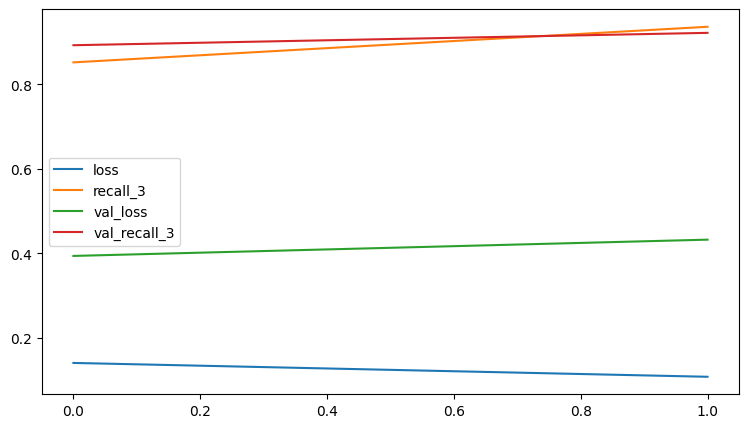

In [399]:
model_loss.plot()

In [400]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model3.predict(val_ds) >= 0.5

print(classification_report(y_test, y_pred))


71/71 [==============================] - 18s 180ms/step

              precision    recall  f1-score   support



           0       0.98      0.90      0.94      1854

           1       0.68      0.92      0.78       410



    accuracy                           0.91      2264

   macro avg       0.83      0.91      0.86      2264

weighted avg       0.93      0.91      0.91      2264




In [401]:
y_train_pred = model3.predict(train_ds) >= 0.5

print(classification_report(y_train, y_train_pred))

637/637 [==============================] - 19s 28ms/step

              precision    recall  f1-score   support



           0       0.99      0.92      0.95     16685

           1       0.72      0.96      0.83      3691



    accuracy                           0.93     20376

   macro avg       0.86      0.94      0.89     20376

weighted avg       0.94      0.93      0.93     20376




71/71 [==============================] - 3s 29ms/step


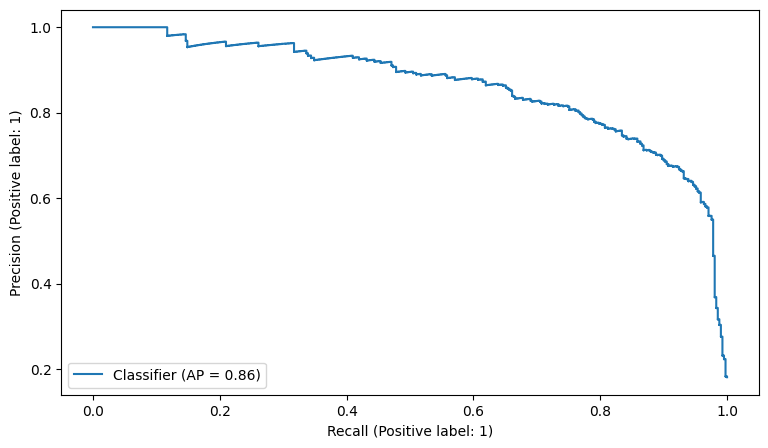

In [402]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score
y_pred_proba = model3.predict(val_ds)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba);

In [403]:
average_precision_score(y_test, y_pred_proba)

0.8632313873526636

In [404]:
BERT_with_weighted_AP = average_precision_score(y_test, y_pred_proba)
BERT_with_weighted_f1 = f1_score(y_test, y_pred)
BERT_with_weighted_rec = recall_score(y_test, y_pred)